In [1]:
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage.segmentation import mark_boundaries
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras.models import Model
from tensorflow import keras
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import shap
import tensorflow as tf
import cv2
import random

In [2]:
# Laden des MNIST Datensatzes und Aufteilen in Trainings- und Testdaten
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
# Normalisierung auf Wertebereich [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# One-Hot-Encoding
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [4]:
# CNN-Modell definieren
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

In [5]:
# Zeige eine Zusammenfassung des Modells an
model.summary()

# Finde die Namen der Convolutional-Layer für Grad-CAM
conv_layers = [layer.name for layer in model.layers if isinstance(layer, Conv2D)]

print("Namen der Convolutional-Layer:")
print(conv_layers)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 64)                1

In [6]:
# Modell kompilieren
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
# Modell trainieren
history = model.fit(train_images, train_labels, epochs=3, batch_size=64, verbose=1)

# Bewertung des Modells auf Testdaten
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print("Test Accuracy:", test_acc)

Epoch 1/3


938/938 [==============================] - 107s 105ms/step - loss: 0.1769 - accuracy: 0.9470
Epoch 2/3
938/938 [==============================] - 103s 110ms/step - loss: 0.0526 - accuracy: 0.9841
Epoch 3/3
938/938 [==============================] - 102s 109ms/step - loss: 0.0360 - accuracy: 0.9892
Test Accuracy: 0.9865999817848206


### SHAP mehrere Bilder

In [8]:
# Wähle die ersten 5 Bilder aus den Testdaten

selected_images = test_images[:5]
selected_images_array = np.array(selected_images)

In [9]:
test_images_exp = np.expand_dims(test_images, axis= -1)
selected_images_array_exp = np.expand_dims(selected_images_array, axis=-1)

In [10]:
# SHAP-Explainer initialisieren

explainer = shap.DeepExplainer(model, shap.sample(selected_images_array_exp, 100))

C:\Users\secre\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [11]:
# Überprüfen der Dimension

print(selected_images_array_exp.shape)
print(test_images_exp.shape)

(5, 28, 28, 1)
(10000, 28, 28, 1)


In [12]:
# SHAP-Werte für die ausgewählten Bilder berechnen

shap_values = explainer.shap_values(selected_images_array_exp)

C:\Users\secre\anaconda3\Lib\site-packages\keras\src\backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


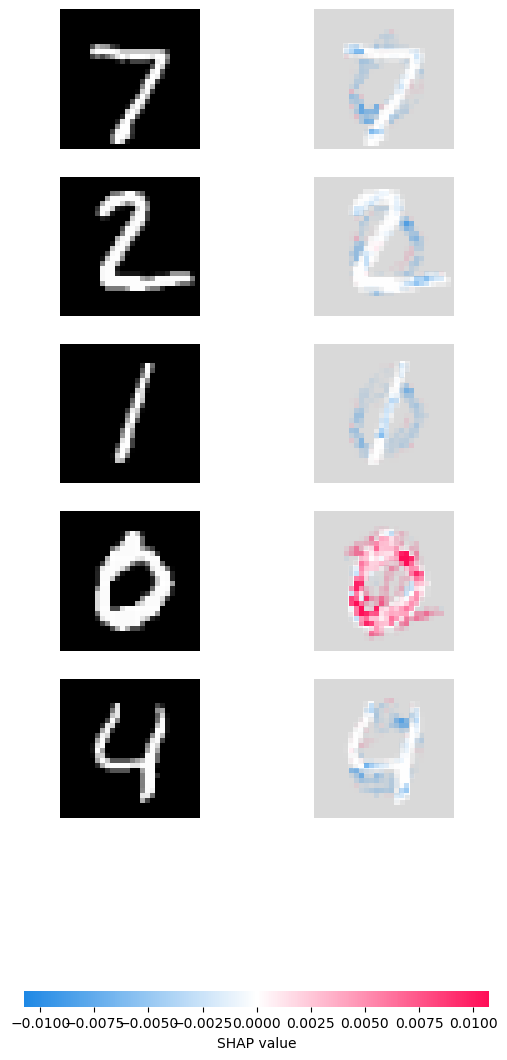

In [13]:
# Visualisierung der SHAP-Werte

shap_image_plot = shap.image_plot(shap_values[:,:,:,:,[0]], selected_images_array_exp)

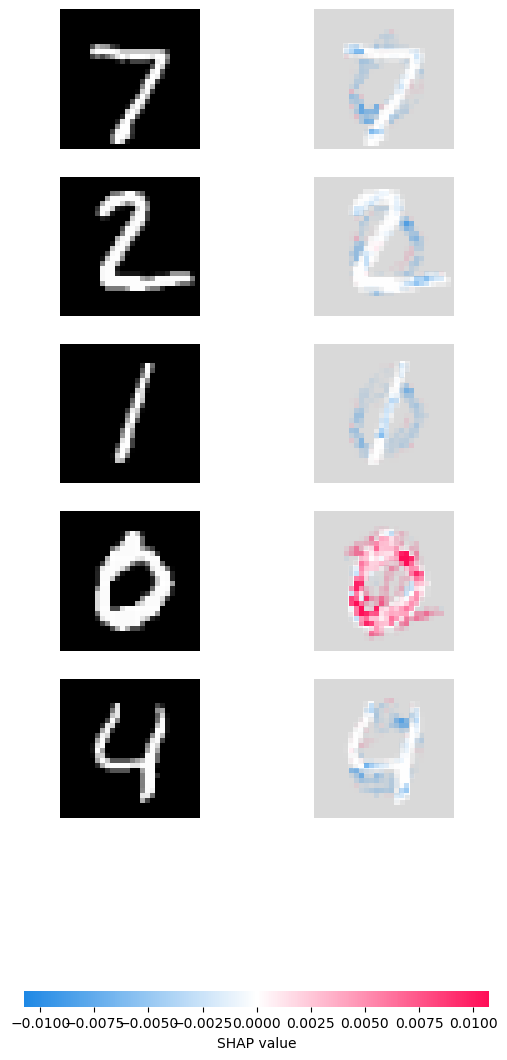

In [14]:
# Erstelle ein neues Figure-Objekt
fig, ax = plt.subplots()

# Zeichne das shap_image_plot in das neue Figure-Objekt
shap.image_plot(shap_values[:,:,:,:,[0]], selected_images_array_exp, show=False)

# Speichere das Bild als .jpg
plt.savefig('shap_image_plot.png', bbox_inches='tight', pad_inches=0)

# Schließe das Plotfenster
plt.close(fig)